# General Health

## Setup

In [1]:
from matplotlib.colors import ListedColormap 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from lib import formatting as sd_formatting
import pyodbc 
import toml
import config_logging
import logging
import urllib.request
import pandas as pd
import colorcet as cc

log = logging.getLogger(__name__)
external_ip = urllib.request.urlopen('https://ident.me').read().decode('utf8')

secrets = toml.load("./.streamlit/secrets.toml")

database_toml = secrets[secrets["database"]["flavour"]] 

database_props = {
                   "driver"   : database_toml["driver"]
                 , "host"     : database_toml["host"]
                 , "port"     : database_toml["port"]
                 , "instance" : database_toml["instance"]
                 , "database" : database_toml["database"]
                 , "username" : database_toml["username"]
                 , "password" : database_toml["password"]
}
db_conn = None
## Connect to the database -- this might move to a factory method to provide the connection


def get_db_conn(database_props):
    try:                      
        db_conn = pyodbc.connect(driver   = database_props["driver"]
                               , server   = "{},{}\{}".format(database_props["host"], database_props["port"], database_props["instance"])
                               , database = database_props["database"]
                               , uid      = database_props["username"]
                               , pwd      = database_props["password"])

        log.info(f"DATABASE CONNECTIVITY from {external_ip}") 
    except Exception as e:
        log.error(f"NO DATABASE CONNECTIVITY from {external_ip}") 
        log.error(e)
        raise Exception("DATABASE CONNECTIVITY")
        
    return db_conn



2022-08-23 18:44:44,983 [INFO] numexpr.utils: NumExpr defaulting to 4 threads.


## Relaod

In [2]:
### Set up
%load_ext autoreload

%autoreload 3
from lib import masters_data_analytics_lib as mlib
from lib import stats as stats
from data.daos import dao_facade_local as dao_fac

db_conn = get_db_conn(database_props)


2022-08-23 18:44:48,297 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-23 18:44:48,305 [DEBUG] matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-08-23 18:44:48,658 [INFO] __main__: DATABASE CONNECTIVITY from 185.44.76.189


## Build the Data

### Search Critera & DAO Access to get all required data

In [3]:
year_from = 2011
year_to   = 2021
city      = "London"

borough   = "Islington"
ward_name = "Holloway"

# ## 27% Black African Carribean at Borough Level
# borough   = "Lewisham"
# ward_name = "Bellingham"



# borough   = "Westminster"    # Highest
# borough   = "Brent"          # Middle
# borough   = "City of London" # Lowest

## We may not have data in the date range we have chosen
## this is true for ALL so fix it Neal

health_year_from = year_from
health_year_to   = year_to

# What do we have? We are only using the max for now
health_min_max_year_df = dao_fac.general_health_min_max_year(db_conn)

health_year_min = health_min_max_year_df["MIN_YEAR"].values[0]
health_year_max = health_min_max_year_df["MAX_YEAR"].values[0]

health_year_from_orig = health_year_from
health_year_to_orig = health_year_to

if health_year_from < int(health_year_min):
    health_year_from = int(health_year_min)
elif health_year_from > int(health_year_max):
    health_year_from = int(health_year_max)

if health_year_to > int(health_year_max):
    health_year_to = int(health_year_max)
elif health_year_to < int(health_year_min):
    health_year_to = int(health_year_min)

log.debug(f"health orig_year_to    :{health_year_to_orig}")
log.debug(f"health search_year_to  :{health_year_to}")

search_term = {"year_from":health_year_from,
               "year_to":health_year_to,
               "borough":borough,
               "ward_name":ward_name}

## City
health_average_year_df         = dao_fac.general_health_ratio_average_years(db_conn, search_term)
## Borough
health_by_borough_year_df      = dao_fac.general_health_ratio_by_borough_years(db_conn, search_term)
## Ward
health_by_borough_ward_year_df = dao_fac.general_health_ratio_by_borough_ward_years(db_conn, search_term)


2022-08-23 18:44:48,860 [DEBUG] root: Retrieving general health min max year
2022-08-23 18:44:48,901 [DEBUG] __main__: health orig_year_to    :2021
2022-08-23 18:44:48,902 [DEBUG] __main__: health search_year_to  :2021
2022-08-23 18:44:48,903 [DEBUG] root: general_health_ratio_average_years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-23 18:44:49,105 [DEBUG] root: genearl_health_ratio_by_borough_years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


2022-08-23 18:44:49,873 [DEBUG] root: general_health_ratio_by_borough_ward_years


C:\DISTRIBUTIONS\Python\Python3_10_2\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
## Health Search Range Narrative
health_narrative_01 = ""
health_in_not_in = "in" if ((health_year_to >= health_year_from_orig) &
                            (health_year_to <= health_year_to)) else "outside"

health_search_range = f"of {health_year_from_orig} to {health_year_to_orig}" if health_year_from_orig != health_year_to_orig else f"{health_year_to_orig}"
health_narrative_search_criters = f"Using the latest general health data from {health_year_to} which is {health_in_not_in} your search range {health_search_range}"

health_narrative_01 = f"{health_narrative_search_criters}. The table below ranks general health in {ward_name}, {borough} and {city}. " + \
"The ranking is highest to lowest percentage from top to bottom. Where there is a difference in general health the cell is shaded, a darker " + \
"shade denotes a difference between borough and ward. Values in [] give the percentage value." 

log.debug(f"\n{health_narrative_01}")

2022-08-23 18:44:55,588 [DEBUG] __main__: 
Using the latest general health data from 2021 which is in your search range of 2011 to 2021. The table below ranks general health in Holloway, Islington and London. The ranking is highest to lowest percentage from top to bottom. Where there is a difference in general health the cell is shaded, a darker shade denotes a difference between borough and ward. Values in [] give the percentage value.


In [5]:
# health_average_year_df
# health_by_borough_year_df
health_by_borough_ward_year_df


,YEAR,LAD,LAD_NAME,WARD_CODE,WARD_NAME,Very Good,Good,Fair,Bad,Very Bad
0,2021,E09000019,Islington,E05000375,Holloway,0.505506,0.311153,0.116666,0.048188,0.018488


#### Build the data and ranking table for ward, borough and city

In [6]:
## Borough & Ward
health_borough_ward_for_year = health_by_borough_ward_year_df.copy()
health_borough_ward_for_year = health_borough_ward_for_year.drop(["YEAR", "LAD", "LAD_NAME", "WARD_CODE", "WARD_NAME"], axis=1)
health_borough_ward_for_year = health_borough_ward_for_year.T.copy()
health_borough_ward_for_year.columns = ["PCT"]
health_borough_ward_for_year = health_borough_ward_for_year.sort_values(by=["PCT"], ascending=False)

## Borough
health_borough_for_year = health_by_borough_year_df[health_by_borough_year_df["LAD_NAME"] == borough].copy()
health_borough_for_year = health_borough_for_year.drop(["YEAR", "LAD", "LAD_NAME"], axis=1)
health_borough_for_year = health_borough_for_year.T.copy()
health_borough_for_year.columns = ["PCT"]
health_borough_for_year = health_borough_for_year.sort_values(by=["PCT"], ascending=False)

## City
health_city_for_year = health_average_year_df.copy()
health_city_for_year
health_city_for_year = health_city_for_year.drop(["YEAR"], axis=1)
health_city_for_year = health_city_for_year.T.copy()
health_city_for_year.columns = ["PCT"]
health_city_for_year = health_city_for_year.sort_values(by=["PCT"], ascending=False)

## Borough Ward
health_ward_pct_sorted = []
for index, row in health_borough_ward_for_year.iterrows():
    health     = index
    health_pct = row.values[0]*100
    health_name_pct_fmt = "{} - [{:,.2f}%]".format(health, health_pct)
    health_ward_pct_sorted.append(health_name_pct_fmt)

## Borough
health_borough_pct_sorted = []
for index, row in health_borough_for_year.iterrows():
    health     = index
    health_pct = row.values[0]*100
    health_name_pct_fmt = "{} - [{:,.2f}%]".format(health, health_pct)
    health_borough_pct_sorted.append(health_name_pct_fmt)

## City
health_city_pct_sorted = []
for index, row in     health_city_for_year.iterrows():
    health     = index
    health_pct = row.values[0]*100
    health_name_pct_fmt = "{} - [{:,.2f}%]".format(health, health_pct)
    health_city_pct_sorted.append(health_name_pct_fmt)

health_ward_borough_city_pct_ranked_merged = [health_ward_pct_sorted, health_borough_pct_sorted, health_city_pct_sorted]
health_ward_borough_city_pct_ranked_merged_df = pd.DataFrame(data=health_ward_borough_city_pct_ranked_merged)

## Rotate 
health_ward_borough_city_pct_ranked_merged_df = health_ward_borough_city_pct_ranked_merged_df.T
health_ward_borough_city_pct_ranked_merged_df.columns = [f"{ward_name}",f"{borough}",f"{city}"]
health_ward_borough_city_pct_ranked_merged_df.index   = [str(rank) for rank in range(1, len(health_ward_borough_city_pct_ranked_merged_df.index)+1)]

health_ward_borough_city_pct_ranked_merged_df

,Holloway,Islington,London
1,Very Good - [50.55%],Very Good - [51.63%],Very Good - [50.56%]
2,Good - [31.12%],Good - [30.75%],Good - [33.22%]
3,Fair - [11.67%],Fair - [11.20%],Fair - [11.23%]
4,Bad - [4.82%],Bad - [4.74%],Bad - [3.77%]
5,Very Bad - [1.85%],Very Bad - [1.68%],Very Bad - [1.23%]


## Build the General Health table with formatting

In [7]:
colour_change = []
## 0 == no change in that cell
## 1 == shade 1 change
## 2 == shade 2 change

for index, row in health_ward_borough_city_pct_ranked_merged_df.iterrows():
    colour_change_row =[]
    
    ## Borough to City Check
    ward_val    = row.iloc[0].split(' - [')[0].strip()
    borough_val = row.iloc[1].split(' - [')[0].strip()
    city_val    = row.iloc[2].split(' - [')[0].strip()
    # log.debug(f"{ward_val}-{borough_val}-{city_val}")

    ward_val_cell_col = 0 if ward_val     == city_val else 1 if ward_val == borough_val else 2
    borough_val_col   = 0 if borough_val  == city_val else 1
    cityl_col         = 0
    
    colour_change_row.append(ward_val_cell_col)
    colour_change_row.append(borough_val_col)
    colour_change_row.append(cityl_col)
    colour_change.append(colour_change_row)

def format_ranking_row(row):
    ## Borough to City Check
    ward_val    = row.iloc[0].split(' - [')[0].strip()
    borough_val = row.iloc[1].split(' - [')[0].strip()
    city_val    = row.iloc[2].split(' - [')[0].strip()
    # log.debug(f"{ward_val}-{borough_val}-{city_val}")

    ward_val_cell_col = "" if ward_val     == city_val else "background-color: #EAFAF1" if ward_val == borough_val else "background-color: #D5F5E3"
    borough_val_col   = "" if borough_val  == city_val else "background-color: #EAFAF1"
    # log.debug(r[1])
    return [ward_val_cell_col] + [borough_val_col] + [""]


from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "110%"),
                             ("text-align", "right")])
]

health_ward_borough_city_pct_ranked_merged_df_html = (health_ward_borough_city_pct_ranked_merged_df.style.set_table_styles(styles).apply(format_ranking_row, axis=1))


In [8]:
health_ward_borough_city_pct_ranked_merged_df_html

,Holloway,Islington,London
1,Very Good - [50.55%],Very Good - [51.63%],Very Good - [50.56%]
2,Good - [31.12%],Good - [30.75%],Good - [33.22%]
3,Fair - [11.67%],Fair - [11.20%],Fair - [11.23%]
4,Bad - [4.82%],Bad - [4.74%],Bad - [3.77%]
5,Very Bad - [1.85%],Very Bad - [1.68%],Very Bad - [1.23%]


In [9]:
health_borough_ward_for_year_name_sorted = health_borough_ward_for_year.sort_index(ascending=True)
health_borough_for_year_name_sorted      = health_borough_for_year.sort_index(ascending=True)
health_city_for_year_name_sorted         = health_city_for_year.sort_index(ascending=True)

health_borough_ward_for_year_name_sorted = health_borough_ward_for_year
health_borough_for_year_name_sorted      = health_borough_for_year
health_city_for_year_name_sorted         = health_city_for_year


## Borough Ward
health_ward_name_sorted = []
for index, row in health_borough_ward_for_year_name_sorted.iterrows():
    health_pct = row.values[0]*100
    health_pct_fmt = "{:,.2f}%".format(health_pct)
    health_ward_name_sorted.append(health_pct_fmt)

## Borough
health_borough_name_sorted = []
for index, row in health_borough_for_year_name_sorted.iterrows():
    health_pct = row.values[0]*100
    health_pct_fmt = "{:,.2f}%".format(health_pct)
    health_borough_name_sorted.append(health_pct_fmt)

## City
health_city_name_sorted = []
for index, row in health_city_for_year_name_sorted.iterrows():
    health_pct = row.values[0]*100
    health_pct_fmt = "{:,.2f}%".format(health_pct)
    health_city_name_sorted.append(health_pct_fmt)

health_ward_borough_city_pct_name_merged = [health_ward_name_sorted, health_borough_name_sorted, health_city_name_sorted]
health_ward_borough_city_pct_name_merged_df = pd.DataFrame(data=health_ward_borough_city_pct_name_merged)

## Rotate 
health_ward_borough_city_pct_name_merged_df = health_ward_borough_city_pct_name_merged_df.T
health_ward_borough_city_pct_name_merged_df.columns = [f"{ward_name}",f"{borough}",f"{city}"]
health_ward_borough_city_pct_name_merged_df.index   = health_borough_ward_for_year_name_sorted.index

health_ward_borough_city_pct_name_merged_df

,Holloway,Islington,London
Very Good,50.55%,51.63%,50.56%
Good,31.12%,30.75%,33.22%
Fair,11.67%,11.20%,11.23%
Bad,4.82%,4.74%,3.77%
Very Bad,1.85%,1.68%,1.23%


In [10]:
def format_pct_row(row):
    
    # log.debug(f"index:{row.name}")
    
    ## Borough to City Check
    name        = row.name
    ward_val    = float(row.iloc[0].split("%")[0].strip())
    borough_val = float(row.iloc[1].split("%")[0].strip())
    city_val    = float(row.iloc[2].split("%")[0].strip())
    
    if (name == "Very Good") or (name == "Good") or (name == "Fair"):
        # log.debug("Very Good, Good or Fair")
        ## It's more than the city so should be green
        if ward_val >= city_val:
            log.debug("Ward more so Green")
            diff = ward_val - city_val
            ward_val_cell_col = ""                          if (diff) < 1.0 else \
                                "background-color: #EAFAF1" if (diff) < 2.0 else \
                                "background-color: #D5F5E3" if (diff) < 3.0 else \
                                "background-color: #ABEBC6" if (diff) < 4.0 else \
                                "background-color: #82E0AA" if (diff) < 5.0 else \
                                "background-color: #58D68D"
            
        ## It's less than, so should be red
        else:
            # log.debug("Ward less so Red")
            #-ve then red shades
            diff = city_val - ward_val
            ward_val_cell_col = ""                          if (diff) < 1.0 else \
                                "background-color: #F5EEF8" if (diff) < 2.0 else \
                                "background-color: #EBDEF0" if (diff) < 3.0 else \
                                "background-color: #D7BDE2" if (diff) < 4.0 else \
                                "background-color: #C39BD3" if (diff) < 5.0 else \
                                "background-color: #AF7AC5"
           
        ## It's more than the city so should be green
        if borough_val >= city_val:
            log.debug("Borough more so Green")
            #+ve then green shades
            diff = borough_val - city_val
            borough_val_col   = ""                          if (diff) < 1.0 else \
                                "background-color: #EAFAF1" if (diff) < 2.0 else \
                                "background-color: #D5F5E3" if (diff) < 3.0 else \
                                "background-color: #ABEBC6" if (diff) < 4.0 else \
                                "background-color: #82E0AA" if (diff) < 5.0 else \
                                "background-color: #58D68D"
            

        ## It's less than, so should be red
        else:
            # log.debug("Borough less so Red")
            #-ve then red shades
            diff = city_val - borough_val
            borough_val_col   = ""                          if (diff) < 1.0 else \
                                "background-color: #F5EEF8" if (diff) < 2.0 else \
                                "background-color: #EBDEF0" if (diff) < 3.0 else \
                                "background-color: #D7BDE2" if (diff) < 4.0 else \
                                "background-color: #C39BD3" if (diff) < 5.0 else \
                                "background-color: #AF7AC5"
    
    ## It's Bad or Very Bad so opposite to the aboce
    else:
        # log.debug("Bad or Very Bad")

        ## It's more than the city so should be red
        if ward_val >= city_val:
            # log.debug("Ward more so Red")
            #-ve then red shades
            diff = ward_val - city_val
            ward_val_cell_col = ""                          if (diff) < 1.0 else \
                                "background-color: #F5EEF8" if (diff) < 2.0 else \
                                "background-color: #EBDEF0" if (diff) < 3.0 else \
                                "background-color: #D7BDE2" if (diff) < 4.0 else \
                                "background-color: #C39BD3" if (diff) < 5.0 else \
                                "background-color: #AF7AC5"
            
        ## It's less than, so should be green
        else:
            # log.debug("Ward less so Green")
            diff = city_val - ward_val
            ward_val_cell_col = ""                          if (diff) < 1.0 else \
                                "background-color: #EAFAF1" if (diff) < 2.0 else \
                                "background-color: #D5F5E3" if (diff) < 3.0 else \
                                "background-color: #ABEBC6" if (diff) < 4.0 else \
                                "background-color: #82E0AA" if (diff) < 5.0 else \
                                "background-color: #58D68D"
           
        ## It's more than the city so should be red
        if borough_val >= city_val:
            # log.debug("Borough more so Red")
            #-ve then red shades
            diff = borough_val - city_val
            borough_val_col   = ""                          if (diff) < 1.0 else \
                                "background-color: #F5EEF8" if (diff) < 2.0 else \
                                "background-color: #EBDEF0" if (diff) < 3.0 else \
                                "background-color: #D7BDE2" if (diff) < 4.0 else \
                                "background-color: #C39BD3" if (diff) < 5.0 else \
                                "background-color: #AF7AC5"
            

        ## It's less than, so should be green
        else:
            # log.debug("Borough less so Green")
            #+ve then green shades
            diff = city_val - borough_val
            borough_val_col   = ""                          if (diff) < 1.0 else \
                                "background-color: #EAFAF1" if (diff) < 2.0 else \
                                "background-color: #D5F5E3" if (diff) < 3.0 else \
                                "background-color: #ABEBC6" if (diff) < 4.0 else \
                                "background-color: #82E0AA" if (diff) < 5.0 else \
                                "background-color: #58D68D"
        

    return [ward_val_cell_col] + [borough_val_col] + [""]


from IPython.display import HTML
styles = [
  dict(selector="tr", props=[("font-size", "110%"),
                             ("text-align", "right")])
]

health_ward_borough_city_pct_name_merged_df_html = (health_ward_borough_city_pct_name_merged_df.style.set_table_styles(styles).apply(format_pct_row, axis=1))
health_ward_borough_city_pct_name_merged_df_html

2022-08-23 18:44:56,555 [DEBUG] __main__: Borough more so Green
2022-08-23 18:44:56,556 [DEBUG] __main__: Ward more so Green


,Holloway,Islington,London
Very Good,50.55%,51.63%,50.56%
Good,31.12%,30.75%,33.22%
Fair,11.67%,11.20%,11.23%
Bad,4.82%,4.74%,3.77%
Very Bad,1.85%,1.68%,1.23%


In [11]:
health_ward_borough_city_pct_name_merged_df.at["Very Good", "Holloway"] = "8%"
health_ward_borough_city_pct_name_merged_df.at["Very Good", "Islington"] = "9%"
health_ward_borough_city_pct_name_merged_df.at["Very Good", "London"] = "10%"

health_ward_borough_city_pct_name_merged_df.at["Good", "Holloway"] = "6%"
health_ward_borough_city_pct_name_merged_df.at["Good", "Islington"] = "7%"
health_ward_borough_city_pct_name_merged_df.at["Good", "London"] = "10%"

health_ward_borough_city_pct_name_merged_df.at["Fair", "Holloway"] = "4%"
health_ward_borough_city_pct_name_merged_df.at["Fair", "Islington"] = "5%"
health_ward_borough_city_pct_name_merged_df.at["Fair", "London"] = "10%"

health_ward_borough_city_pct_name_merged_df_html = (health_ward_borough_city_pct_name_merged_df.style.set_table_styles(styles).apply(format_pct_row, axis=1))
health_ward_borough_city_pct_name_merged_df_html

,Holloway,Islington,London
Very Good,8%,9%,10%
Good,6%,7%,10%
Fair,4%,5%,10%
Bad,4.82%,4.74%,3.77%
Very Bad,1.85%,1.68%,1.23%


In [12]:
health_narrative_02 = f"The table below shows the percentage levels of general health (Very Good - Very Bad) in {ward_name}, {borough} and {city} in the year {health_year_to}" + \
". Value shading indicates a difference from the city level from 1 to 5 percent in 1 percent intervals." + \
" The shade darkens with an increase in difference. Increases and decreases use different colours for clarity. Increases in Fair to Very Good are coloured the same as " + \
"decreases in Bad and Very Bad."

log.debug(f"\n{health_narrative_02}")

2022-08-23 18:44:56,828 [DEBUG] __main__: 
The table below shows the percentage levels of general health (Very Good - Very Bad) in Holloway, Islington and London in the year 2021. Value shading indicates a difference from the city level from 1 to 5 percent in 1 percent intervals. The shade darkens with an increase in difference. Increases and decreases use different colours for clarity. Increases in Fair to Very Good are coloured the same as decreases in Bad and Very Bad.


In [13]:
health_ward_borough_city_pct_name_merged_df_html

,Holloway,Islington,London
Very Good,8%,9%,10%
Good,6%,7%,10%
Fair,4%,5%,10%
Bad,4.82%,4.74%,3.77%
Very Bad,1.85%,1.68%,1.23%


In [14]:
health_by_borough_year_df
health_by_borough_year_df_bar = health_by_borough_year_df[["LAD_NAME", "Very Good", "Good", "Fair", "Bad", "Very Bad"]]
health_by_borough_year_df_bar = health_by_borough_year_df_bar.set_index("LAD_NAME")
health_by_borough_year_df_bar.index.name = "Borough"
# health_by_borough_year_df_bar

# PARK FOR NOW

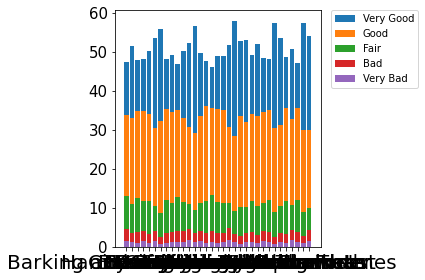

In [15]:
###
### HORIZONTAL PLOT 100% BY BOROUGH - APPENDIX
###

stacked_data = health_by_borough_year_df_bar.apply(lambda x: x*100, axis=1)
# stacked_data = health_by_borough_year_df_bar
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap 
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# ax = stacked_data.plot.bar(stacked=False, figsize=(20, 15), zorder=1)


plt.bar(stacked_data.index, stacked_data["Very Good"].values, label="Very Good")
plt.bar(stacked_data.index, stacked_data["Good"].values, label="Good")
plt.bar(stacked_data.index, stacked_data["Fair"].values, label="Fair")
plt.bar(stacked_data.index, stacked_data["Bad"].values, label="Bad")
plt.bar(stacked_data.index, stacked_data["Very Bad"].values, label="Very Bad")

plt.rcParams["figure.figsize"] = (20,15)


# ax = stacked_data.plot(kind='bar', stacked=True, figsize=(20, 15))

# ax.grid(False)
# ax.set_title("General Health {}".format(health_year_to), fontsize=20)
# ax.set_ylabel("% of population")
# ax.set_xlabel("")
# ax.legend(title="legend")
# ax.legend(loc="upper right")

plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
# plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

Text(0.5, 0, 'Family Member')

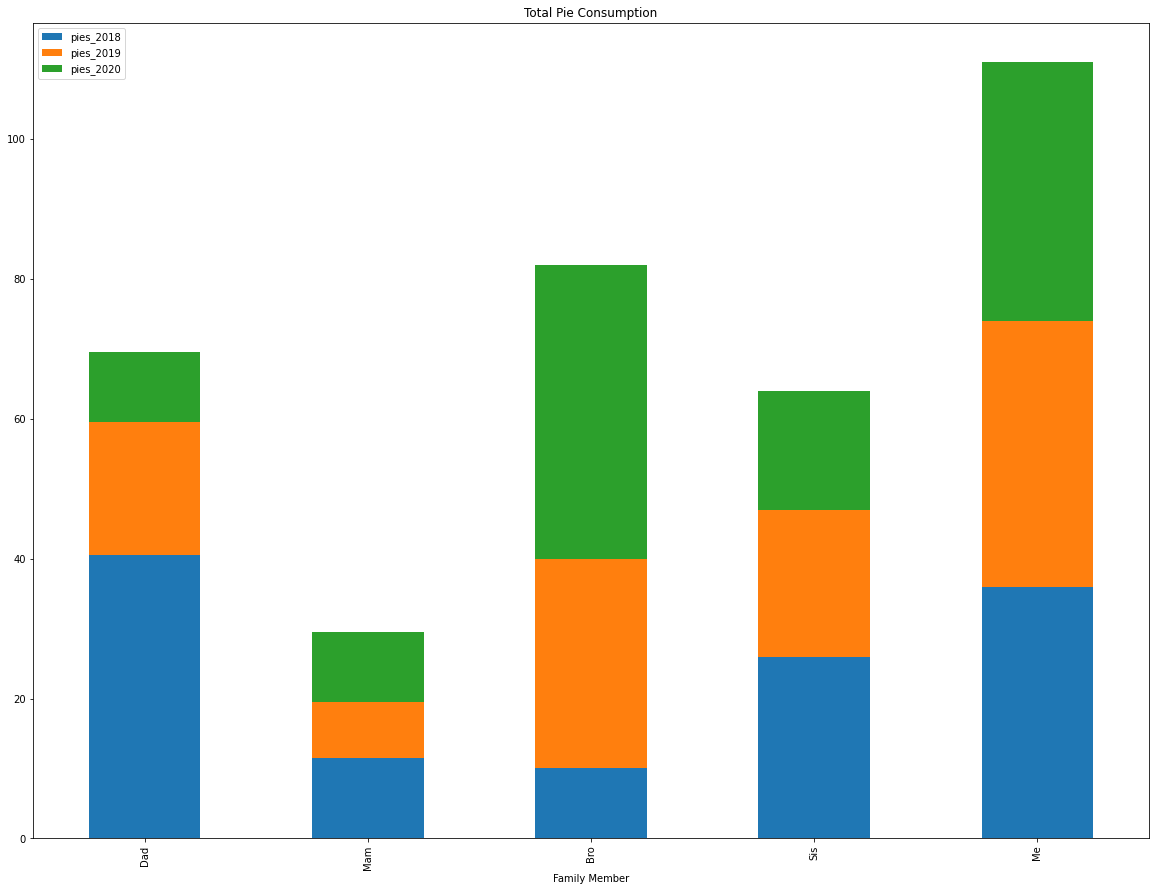

In [16]:
plotdata = pd.DataFrame({
    "pies_2018":[40.5, 11.5, 10, 26, 36],
    "pies_2019":[19, 8, 30, 21, 38],
    "pies_2020":[10, 10, 42, 17, 37]
    }, 
    index=["Dad", "Mam", "Bro", "Sis", "Me"]
)


stacked_data = stacked_data[stacked_data.columns[::-1]]

plotdata.plot(kind='bar', stacked=True)
plt.title("Total Pie Consumption")
plt.xlabel("Family Member")

In [17]:
plotdata

,pies_2018,pies_2019,pies_2020
Dad,40.5,19,10
Mam,11.5,8,10
Bro,10.0,30,42
Sis,26.0,21,17
Me,36.0,38,37


Text(0.5, 0, 'Family Member')

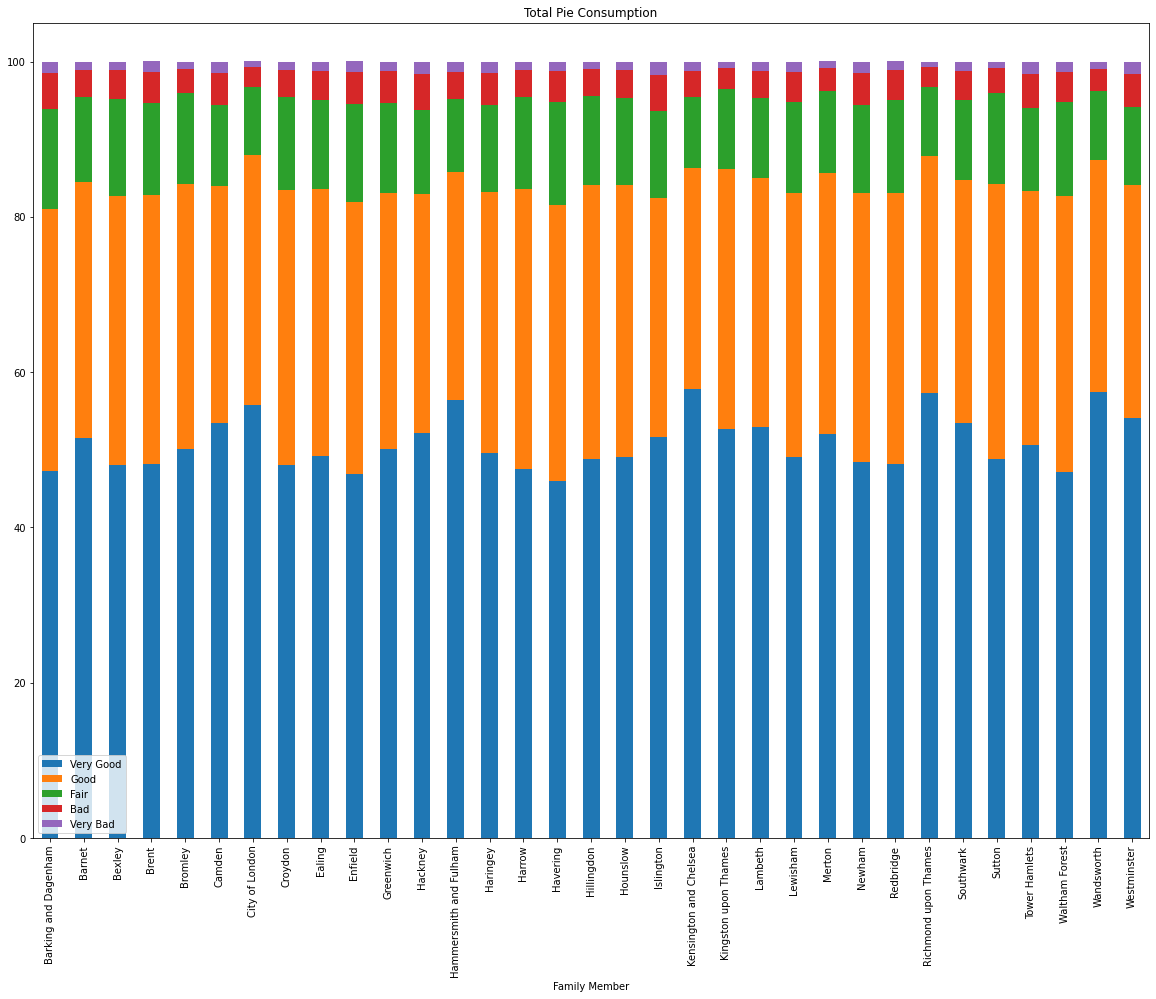

In [18]:
stacked_data = stacked_data[stacked_data.columns[::-1]]

stacked_data.plot(kind='bar', stacked=True)
plt.title("Total Pie Consumption")
plt.xlabel("Family Member")

# REPORT PAGE

In [19]:
print(health_narrative_01)

Using the latest general health data from 2021 which is in your search range of 2011 to 2021. The table below ranks general health in Holloway, Islington and London. The ranking is highest to lowest percentage from top to bottom. Where there is a difference in general health the cell is shaded, a darker shade denotes a difference between borough and ward. Values in [] give the percentage value.


In [23]:
health_ward_borough_city_pct_ranked_merged_df_html

,Holloway,Islington,London
1,Very Good - [50.55%],Very Good - [51.63%],Very Good - [50.56%]
2,Good - [31.12%],Good - [30.75%],Good - [33.22%]
3,Fair - [11.67%],Fair - [11.20%],Fair - [11.23%]
4,Bad - [4.82%],Bad - [4.74%],Bad - [3.77%]
5,Very Bad - [1.85%],Very Bad - [1.68%],Very Bad - [1.23%]


In [21]:
print(health_narrative_02)

The table below shows the percentage levels of general health (Very Good - Very Bad) in Holloway, Islington and London in the year 2021. Value shading indicates a difference from the city level from 1 to 5 percent in 1 percent intervals. The shade darkens with an increase in difference. Increases and decreases use different colours for clarity. Increases in Fair to Very Good are coloured the same as decreases in Bad and Very Bad.


In [22]:
health_ward_borough_city_pct_name_merged_df_html

,Holloway,Islington,London
Very Good,8%,9%,10%
Good,6%,7%,10%
Fair,4%,5%,10%
Bad,4.82%,4.74%,3.77%
Very Bad,1.85%,1.68%,1.23%
